**Nuevo Notebook: ``04_feature_selection_experiment.ipynb``**

Ahora sí, creamos el notebook para aplicar tu técnica de RFE y medir su impacto. Este script asume que 03_model_training_baseline.ipynb ya se ha ejecutado y tenemos esos resultados como punto de comparación.

Librerías importadas exitosamente.

Cargando los conjuntos de datos de entrenamiento y prueba (completos)...
Datos cargados exitosamente.

Iniciando selección de características con RFE para encontrar el top 10...

Características seleccionadas por RFE:
 - sqft
 - bathrooms
 - house_age
 - price_per_sqft
 - bed_bath_ratio
 - location_Downtown
 - location_Suburb
 - location_Urban
 - location_Waterfront
 - condition

Características ignoradas por RFE:
 - bedrooms
 - location_Mountain
 - location_Rural

Nueva forma de X_train (con RFE): (61, 10)

Re-entrenando modelos con el subconjunto de características de RFE...
MLflow configurado y registrando en: http://localhost:5555

--- Entrenando (RFE): LinearRegression ---


2025/10/05 23:26:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para LinearRegression (RFE) -> R2: 0.9926, RMSE: $18,620.18
🏃 View run LinearRegression at: http://localhost:5555/#/experiments/2/runs/98b1bfd5a1ae4a2c87b85f7be410b78d
🧪 View experiment at: http://localhost:5555/#/experiments/2

--- Entrenando (RFE): Ridge ---


2025/10/05 23:26:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para Ridge (RFE) -> R2: 0.9940, RMSE: $16,671.55
🏃 View run Ridge at: http://localhost:5555/#/experiments/2/runs/f212fb6efb6d4e9ba79e1f53e9a25ea7
🧪 View experiment at: http://localhost:5555/#/experiments/2

--- Entrenando (RFE): RandomForest ---


2025/10/05 23:26:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para RandomForest (RFE) -> R2: 0.9855, RMSE: $25,985.71
🏃 View run RandomForest at: http://localhost:5555/#/experiments/2/runs/9da67296c406484795c9de449fe2c3eb
🧪 View experiment at: http://localhost:5555/#/experiments/2

--- Entrenando (RFE): GradientBoosting ---


2025/10/05 23:26:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para GradientBoosting (RFE) -> R2: 0.9856, RMSE: $25,909.77
🏃 View run GradientBoosting at: http://localhost:5555/#/experiments/2/runs/41739067a60a419d859c512f5242d3d3
🧪 View experiment at: http://localhost:5555/#/experiments/2

--- Entrenando (RFE): XGBoost ---


2025/10/05 23:26:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Resultados para XGBoost (RFE) -> R2: 0.9738, RMSE: $34,904.30
🏃 View run XGBoost at: http://localhost:5555/#/experiments/2/runs/ab45bf47316e4e7a930d45f07af60b33
🧪 View experiment at: http://localhost:5555/#/experiments/2
🏃 View run RFE_Model_Comparison at: http://localhost:5555/#/experiments/2/runs/52be959939844d9cbd69ab28fb1662ea
🧪 View experiment at: http://localhost:5555/#/experiments/2

--- Resumen y Visualización de Resultados del Experimento RFE ---

Tabla de resultados con características seleccionadas por RFE:
                        r2          rmse           mae
Ridge             0.994033  16671.545903   8162.018109
LinearRegression  0.992557  18620.180500   8366.198931
GradientBoosting  0.985588  25909.770967  14876.083681
RandomForest      0.985503  25985.713022  13346.875000
XGBoost           0.973844  34904.297959  20988.189453


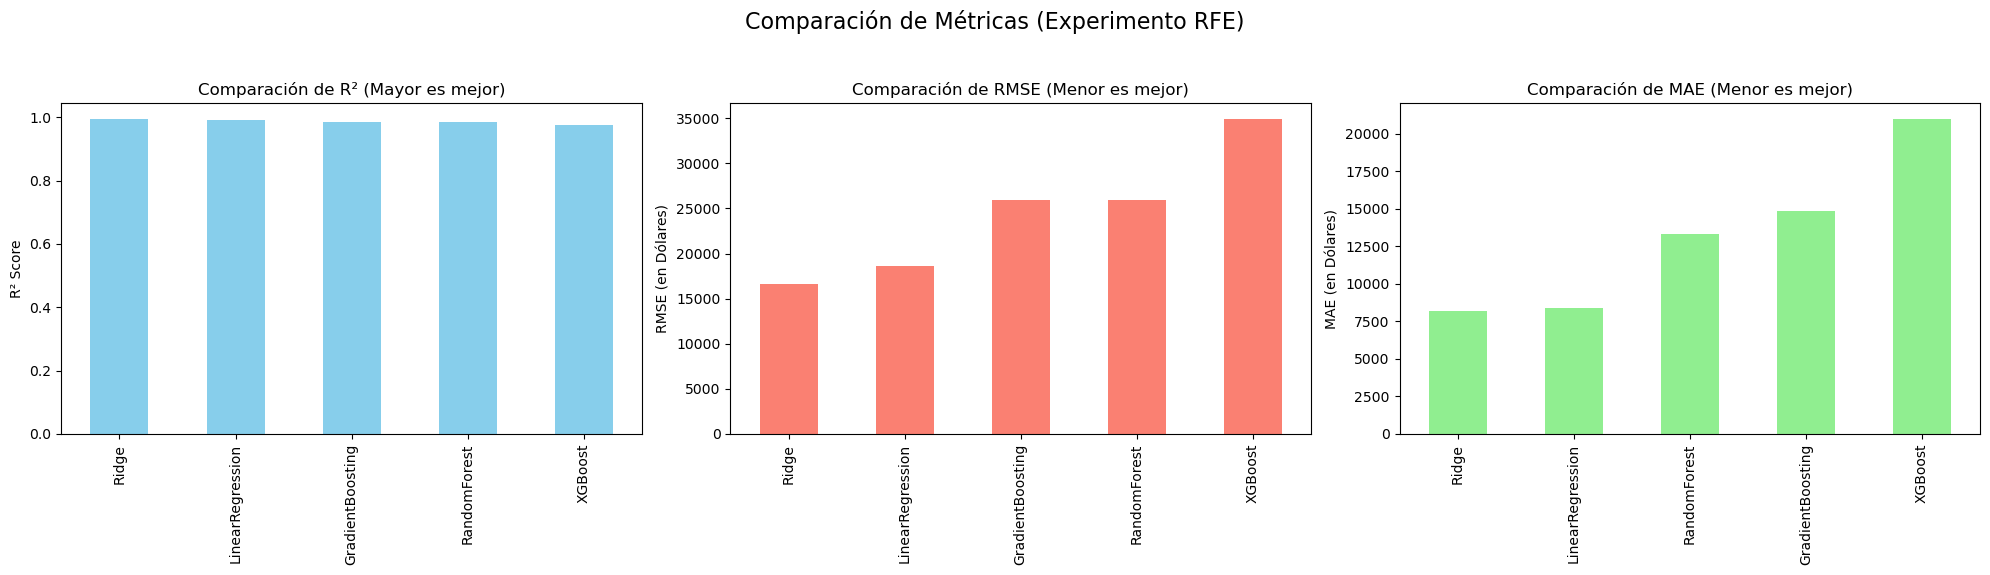


🏆 Mejor Modelo (basado en R²): Ridge
   - R² Score: 0.9940
   - MAE: $8,162.02
   - RMSE: $16,671.55

Configuración del mejor modelo RFE guardada en: ../models/rfe_model_config.yaml

--- CONCLUSIÓN DEL EXPERIMENTO ---
El mejor modelo con RFE es: Ridge con R²: 0.9940, RMSE: $16,671.55


In [5]:
# ==============================================================================
# PASO 1: IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import yaml
import os

from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

from contextlib import nullcontext

print("Librerías importadas exitosamente.")

# ==============================================================================
# PASO 2: CONFIGURACIÓN Y CARGA DE DATOS
# ==============================================================================
mlflow_tracking_uri = 'http://localhost:5555'

print("\nCargando los conjuntos de datos de entrenamiento y prueba (completos)...")
try:
    X_train_full = pd.read_csv('../data/processed/X_train.csv')
    X_test_full = pd.read_csv('../data/processed/X_test.csv')
    y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
    y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()
    print("Datos cargados exitosamente.")
except FileNotFoundError:
    print("ERROR: Archivos no encontrados. Asegúrate de haber ejecutado el notebook '02' primero.")
    exit()

# ==============================================================================
# PASO 3: SELECCIÓN DE CARACTERÍSTICAS CON RFE
# ==============================================================================
print("\nIniciando selección de características con RFE para encontrar el top 10...")
# Se usa un modelo base de XGBoost para determinar la importancia de las características.
# RFE entrenará este modelo repetidamente para encontrar el mejor subconjunto.
estimator_rfe = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
rfe_selector = RFE(estimator=estimator_rfe, n_features_to_select=10, step=1)
rfe_selector.fit(X_train_full, y_train)

# Obtener las listas de características seleccionadas e ignoradas
rfe_selected_features = X_train_full.columns[rfe_selector.support_]
rfe_ignored_features = X_train_full.columns[~rfe_selector.support_]

print("\nCaracterísticas seleccionadas por RFE:")
for feature in rfe_selected_features:
    print(f" - {feature}")

print("\nCaracterísticas ignoradas por RFE:")
for feature in rfe_ignored_features:
    print(f" - {feature}")
    
# Filtrar los conjuntos de datos para usar solo las características seleccionadas
X_train_rfe = X_train_full[rfe_selected_features]
X_test_rfe = X_test_full[rfe_selected_features]

print(f"\nNueva forma de X_train (con RFE): {X_train_rfe.shape}")

# ==============================================================================
# PASO 4: RE-ENTRENAMIENTO DE MODELOS CON CARACTERÍSTICAS SELECCIONADAS
# ==============================================================================
print("\nRe-entrenando modelos con el subconjunto de características de RFE...")
# Se utilizan los mismos modelos y grillas para una comparación justa con la línea base.
models = {
    'LinearRegression': LinearRegression(), 'Ridge': Ridge(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
}
param_grids = {
    'LinearRegression': {}, 'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'RandomForest': {'n_estimators': [100, 150], 'max_depth': [10, 20, None]},
    'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]}
}

# Misma función de evaluación del notebook anterior.
def evaluate_model(model_name, model, params, X_train, y_train, X_test, y_test):
    if params:
        grid_search = GridSearchCV(model, params, cv=3, scoring='r2', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_model = model
    y_pred = best_model.predict(X_test)
    r2 = r2_score(y_test, y_pred); mae = mean_absolute_error(y_test, y_pred); rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'model': best_model, 'params': best_model.get_params()}

# Configurar el experimento en MLflow
try:
    mlflow.set_tracking_uri(mlflow_tracking_uri)
    mlflow.set_experiment("House Price - Feature Selection")
    mlflow_enabled = True
    print(f"MLflow configurado y registrando en: {mlflow_tracking_uri}")
except Exception as e:
    mlflow_enabled = False
    print(f"Advertencia: No se pudo conectar a MLflow. Causa: {e}")



# Ciclo de experimentación con registro en MLflow
results_rfe = {}
with mlflow.start_run(run_name="RFE_Model_Comparison") if mlflow_enabled else nullcontext() as parent_run:
    if mlflow_enabled:
        mlflow.log_param("feature_selection_method", "RFE")
        mlflow.log_param("n_features", 10)

    for name, model in models.items():
        print(f"\n--- Entrenando (RFE): {name} ---")
        with mlflow.start_run(run_name=name, nested=True) if mlflow_enabled else nullcontext() as child_run:
            evaluation = evaluate_model(name, model, param_grids[name], X_train_rfe, y_train, X_test_rfe, y_test)
            results_rfe[name] = evaluation

            if mlflow_enabled:
                mlflow.log_params(evaluation['params'])
                mlflow.log_metrics({'mae': evaluation['mae'], 'rmse': evaluation['rmse'], 'r2': evaluation['r2']})
                mlflow.sklearn.log_model(evaluation['model'], name=name)

            print(f"Resultados para {name} (RFE) -> R2: {evaluation['r2']:.4f}, RMSE: ${evaluation['rmse']:,.2f}")

# ==============================================================================
# PASO 5: ANÁLISIS DE RESULTADOS DEL EXPERIMENTO RFE
# ==============================================================================
print("\n--- Resumen y Visualización de Resultados del Experimento RFE ---")
results_rfe_df = pd.DataFrame({
    model: {metric: value for metric, value in metrics.items() if isinstance(value, (int, float))}
    for model, metrics in results_rfe.items()
}).T.sort_values(by='r2', ascending=False)

print("\nTabla de resultados con características seleccionadas por RFE:")
print(results_rfe_df)

# Función para graficar las métricas de los modelos
def plot_model_metrics(results_df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    results_df['r2'].sort_values(ascending=False).plot(kind='bar', ax=axes[0], color='skyblue', title='Comparación de R² (Mayor es mejor)')
    axes[0].set_ylabel('R² Score')
    results_df['rmse'].sort_values(ascending=True).plot(kind='bar', ax=axes[1], color='salmon', title='Comparación de RMSE (Menor es mejor)')
    axes[1].set_ylabel('RMSE (en Dólares)')
    results_df['mae'].sort_values(ascending=True).plot(kind='bar', ax=axes[2], color='lightgreen', title='Comparación de MAE (Menor es mejor)')
    axes[2].set_ylabel('MAE (en Dólares)')
    plt.suptitle('Comparación de Métricas (Experimento RFE)', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Graficar las métricas de los modelos
plot_model_metrics(results_rfe_df)

# Encontrar y guardar la configuración del mejor modelo
best_model_name_rfe = results_rfe_df.index[0]
best_model_details_rfe = results_rfe[best_model_name_rfe]

print(f"\n🏆 Mejor Modelo (basado en R²): {best_model_name_rfe}")
print(f"   - R² Score: {best_model_details_rfe['r2']:.4f}")
print(f"   - MAE: ${best_model_details_rfe['mae']:,.2f}")
print(f"   - RMSE: ${best_model_details_rfe['rmse']:,.2f}")

# Crear el diccionario de configuración para el mejor modelo
model_config_rfe = {
    'experiment_name': 'rfe_10_features',
    'model_name': best_model_name_rfe,
    'parameters': best_model_details_rfe['params'],
    'metrics': {
        'r2': best_model_details_rfe['r2'],
        'mae': best_model_details_rfe['mae'],
        'rmse': best_model_details_rfe['rmse']
    },
    'features_used': rfe_selected_features.tolist()
}

# Guardar la configuración del modelo ganador en un archivo YAML
config_path_rfe = '../models/rfe_model_config.yaml'
os.makedirs(os.path.dirname(config_path_rfe), exist_ok=True)
with open(config_path_rfe, 'w') as f:
    yaml.dump(model_config_rfe, f, default_flow_style=False, sort_keys=False)

print(f"\nConfiguración del mejor modelo RFE guardada en: {config_path_rfe}")
print("\n--- CONCLUSIÓN DEL EXPERIMENTO ---")
print(f"El mejor modelo con RFE es: {best_model_name_rfe} con R²: {best_model_details_rfe['r2']:.4f}, RMSE: ${best_model_details_rfe['rmse']:,.2f}")

In [6]:
# ==============================================================================
# PASO 6: COMPARACIÓN CON LÍNEA BASE Y DECISIÓN FINAL
# ==============================================================================
print("\n--- Comparación Final con Experimento de Línea Base ---")
try:
    with open('../models/baseline_model_config.yaml', 'r') as f:
        try:
            # Intentar carga segura primero
            config_baseline = yaml.safe_load(f)
        except yaml.YAMLError:
            # Si el YAML contiene tags de objetos Python (p. ej. numpy scalars)
            # intentamos una carga menos restrictiva como respaldo.
            f.seek(0)
            config_baseline = yaml.load(f, Loader=yaml.Loader)
    # Normalizar posibles numpy scalars a tipos nativos de Python para evitar futuros dumps con tags
    if isinstance(config_baseline, dict) and 'metrics' in config_baseline and isinstance(config_baseline['metrics'], dict):
        for k, v in list(config_baseline['metrics'].items()):
            try:
                config_baseline['metrics'][k] = float(v)
            except Exception:
                # si no se puede convertir, dejar tal cual
                pass
    print("Resultados del mejor modelo de línea base cargados.")
except FileNotFoundError:
    print("ERROR: No se encontró 'baseline_model_config.yaml'. Ejecuta el notebook '03' primero.")
    config_baseline = None

if config_baseline:
    best_model_name_rfe = results_rfe_df.index[0]
    best_model_metrics_rfe = results_rfe_df.loc[best_model_name_rfe]

    baseline_model_name = config_baseline.get('best_model_name', 'N/A')
    baseline_metrics = config_baseline.get('metrics', {})
    baseline_r2 = float(baseline_metrics.get('r2', np.nan))
    baseline_rmse = float(baseline_metrics.get('rmse', np.nan))

    # Crear una tabla de comparación
    comparison_df = pd.DataFrame({
        'Baseline (Todas las Features)': {'Model': baseline_model_name, 'R2': baseline_r2, 'RMSE': baseline_rmse},
        'Feature Selection (RFE)': {'Model': best_model_name_rfe, 'R2': best_model_metrics_rfe['r2'], 'RMSE': best_model_metrics_rfe['rmse']}
    }).T
    
    print("\nTabla Comparativa Final:")
    print(comparison_df)

    # Decisión final automatizada
    if not np.isnan(baseline_rmse) and best_model_metrics_rfe['rmse'] < baseline_rmse:
        print("\n🏆 VEREDICTO: El modelo con selección de características (RFE) es el ganador (menor RMSE).")
        final_winner_config = {
            'experiment_name': 'rfe_10_features', 'model_name': best_model_name_rfe,
            'parameters': results_rfe[best_model_name_rfe]['params'],
            'target_variable': 'price',
            'metrics': best_model_metrics_rfe.to_dict(),
            'features_used': rfe_selected_features.tolist()
        }
    else:
        print("\n🏆 VEREDICTO: El modelo de línea base (todas las características) es el ganador.")
        # Aseguramos que el config del baseline también tenga la estructura final
        final_winner_config = {
            'experiment_name': config_baseline.get('experiment_name', 'baseline'),
            'model_name': baseline_model_name,
            'target_variable': 'price', # <-- LÍNEA AÑADIDA
            'parameters': config_baseline.get('parameters', {}),
            'metrics': baseline_metrics,
            'features_used': config_baseline.get('features_used', [])
        }

    # Guardar la configuración del modelo ganador
    final_config_path = '../models/best_model_config.yaml'
    with open(final_config_path, 'w') as f:
        yaml.dump(final_winner_config, f, default_flow_style=False, sort_keys=False)
    
    print(f"\nConfiguración del modelo campeón guardada en: {final_config_path}")


--- Comparación Final con Experimento de Línea Base ---
Resultados del mejor modelo de línea base cargados.

Tabla Comparativa Final:
                               Model        R2          RMSE
Baseline (Todas las Features)  Ridge  0.992449  18754.660164
Feature Selection (RFE)        Ridge  0.994033  16671.545903

🏆 VEREDICTO: El modelo con selección de características (RFE) es el ganador (menor RMSE).

Configuración del modelo campeón guardada en: ../models/best_model_config.yaml
